# Classification - Create Inputs and Outputs

In [1]:
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/anaconda3/envs/testenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/michael/anaconda3/envs/testenv/lib

In [2]:
# Make Linearly Separable(ish) Dataset
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

# preprocess dataset, split into training and test par
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

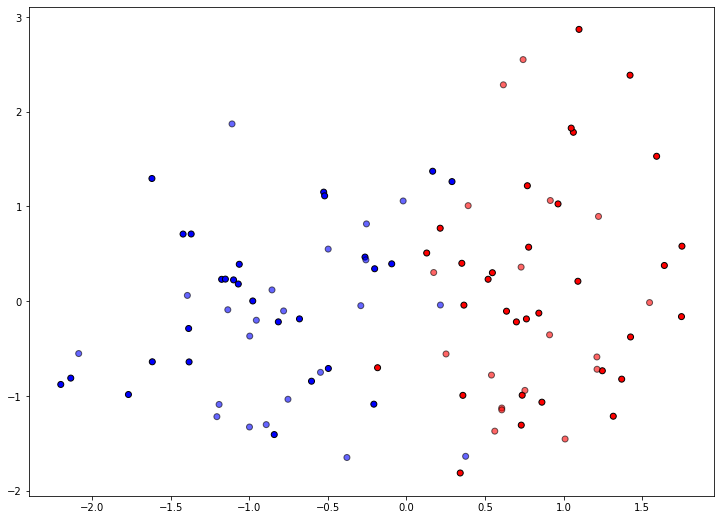

In [3]:
# Plot Dataset
figure = plt.figure(figsize=(27, 9))
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 1 + 1, 1)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')

In [4]:
clf = SVC()
clf.set_params(kernel='linear', probability=True).fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [5]:
y_encoded = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

pred_probs = clf.predict_proba(X)
preds = np.argmax(pred_probs, axis=1)
pred_rounded = np.where(pred_probs > 0.5, 1, 0)

In [37]:
sess = K.get_session()
y_tensor = tf.convert_to_tensor(y_encoded)
pred_tensor = tf.cast(tf.convert_to_tensor(pred_rounded), tf.float64)
pred_prob_tensor = tf.convert_to_tensor(pred_probs)

In [17]:
print(y_encoded.shape, pred_rounded.shape)

(100, 2) (100, 2)


In [18]:
tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
print(tp, tn, fp, fn)

47 49 1 3


## Precision

In [19]:
from sklearn.metrics import precision_score
precision_score(y, preds, average='macro')

0.9607371794871795

In [20]:
def np_precision_score(y_encoded, pred_rounded):
    # Precision: tp/(tp+fp)
    tp = np.sum(np.logical_and(np.equal(pred_rounded, 1), (y_encoded == pred_rounded)), axis=0)
    fp = np.sum(np.logical_and(np.equal(pred_rounded, 1), np.not_equal(pred_rounded, y_encoded)), axis=0)
    return np.mean(tp/np.sum((tp, fp), axis=0), axis=0)
np_precision_score(y_encoded, pred_rounded)

0.9607371794871795

In [32]:
def tf_precision_score(y_encoded, pred_rounded):
    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(pred_rounded, 1), tf.equal(y_encoded, pred_rounded)), tf.int32), axis=0)
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(pred_rounded, 1), tf.not_equal(y_encoded, pred_rounded)), tf.int32), axis=0)
    return tf.reduce_mean(tf.divide(tp, tf.add(tp, fp)))
tf_precision_score(y_tensor, pred_tensor).eval(session=sess)

0.9607371794871795

## Recall

In [34]:
from sklearn.metrics import recall_score
recall_score(y, preds, average='macro')

0.96

In [35]:
def np_recall_score(y_encoded, pred_rounded):
    # Recall: tp/(tp+fn)
    tp = np.sum(np.logical_and(np.equal(pred_rounded, 1), (y_encoded == pred_rounded)), axis=0)
    fn = np.sum(np.logical_and(np.equal(pred_rounded, 0), (y_encoded != pred_rounded)), axis=0)
    return np.mean(tp/(tp+fn))
np_recall_score(y_encoded, pred_rounded)

0.96

In [36]:
def tf_recall_score(y_encoded, pred_rounded):
    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(pred_rounded, 1), tf.equal(y_encoded, pred_rounded)), tf.int32), axis=0)
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(pred_rounded, 0), tf.not_equal(y_encoded, pred_rounded)), tf.int32), axis=0)
    return tf.reduce_mean(tf.divide(tp, tf.add(tp, fn)))
tf_recall_score(y_tensor, pred_tensor).eval(session=sess)

0.96

## F1

In [14]:
from sklearn.metrics import f1_score
f1_score(y, preds, average='macro')

0.949954959463517

In [15]:
def np_f1_score(y_encoded, pred_rounded):
    # F1 = 2*(prec*rec)/(prec+rec)
    prec = np_precision_score(y_encoded, pred_rounded)
    rec = np_recall_score(y_encoded, pred_rounded)
    return 2*(prec*rec)/(prec+rec)
np_f1_score(y_encoded, pred_rounded)

0.9552288351573041

## Binary Cross Entropy Loss

The general categorical cross entropy equation over multiple classes (for a given class x)
Where the ground truth probability of class x is $p(x)$, and the predicted probability of a class is $q(x)$, is: 

$$
\begin{align}
    CE = -\sum_x{ p(x)*log(q(x)) }
\end{align}
$$

Binary cross entropy is a special case of Categorical Cross Entropy - it can be shown with the following equation:

$$
\begin{align}
    BCE = - \left( p(x)*log(q(x)) + (1-p(x))*log(1-q(x)) \right)
\end{align}
$$
**Note:** The left side becomes 0 when p(x) = 0, while the right side becomes 0 when p(x) = 1

In [46]:
from sklearn.metrics import log_loss
log_loss(y, pred_probs)

0.13234742117205314

In [52]:
def tf_bce_loss(y_encoded, pred_prob):
    # We know that log(1) = 0 (and therefore the derivative will be 1/0=inf), and log(0) = inf - therefore we cannot have 0 or 1 in our predictions
    clipped_pred_prob = tf.clip_by_value(pred_prob, clip_value_min=tf.keras.backend.epsilon(), clip_value_max=1.0-tf.keras.backend.epsilon())
    bce = -1.0*tf.where(tf.equal(y_encoded, 1), tf.log(clipped_pred_prob), tf.log(1.0-clipped_pred_prob))
    return tf.reduce_mean(bce)
tf_bce_loss(y_tensor, pred_prob_tensor).eval(session=sess)

0.13234742404529753

## Sigmoid Activation
Skipping for now - this one should be easy because its stable and so is the derivative